# DRL Test 7-1

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import yfinance as yf
import random
import os

In [40]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA or CPU: ", device)
print("Device: ",torch.cuda.get_device_name(0))

CUDA or CPU:  cuda
Device:  NVIDIA GeForce RTX 4080


In [41]:
# Experiment parameters
WINDOW_SIZE = 120  # Rolling window size for state representation
STD_WINDOW_SIZE = 20
NUM_ASSETS = 14   # Example number of assets
ENV_STEP_SIZE = 1
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-4
DISCOUNT_FACTOR = 0.9
BATCH_SIZE = 50
EPISODES = 250
THETA = 0.5
SIGMA = 0.02

In [42]:
def calculate_features(data, window_size):
    # Ensure we have enough data for the specified window sizes
    if len(data) < STD_WINDOW_SIZE + window_size:
        raise ValueError("Data length must be at least STD_WINDOW_SIZE + window_size to calculate rolling metrics.")
    
    # Convert data to a tensor and move to GPU
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)

    # Initialize tensors to store results for the rolling metrics
    num_assets = data.shape[1]
    rolling_returns = data_tensor[STD_WINDOW_SIZE:STD_WINDOW_SIZE + window_size]  # Use the returns directly
    rolling_volatilities = torch.zeros((window_size, num_assets), device=device)
    rolling_drawdowns = torch.zeros((window_size, num_assets), device=device)

    # Calculate cumulative returns to determine drawdowns
    cumulative_returns = torch.cumprod(1 + rolling_returns, dim=0)
    peak_values = torch.cummax(cumulative_returns, dim=0).values
    rolling_drawdowns = torch.where(cumulative_returns < peak_values, cumulative_returns - peak_values, torch.tensor(0.0, device=device))

    # Calculate rolling volatilities using an inner window of `std_size`
    for i in range(window_size):
        idx = STD_WINDOW_SIZE + i
        volatility_window = data_tensor[idx - STD_WINDOW_SIZE:idx]  # Only previous `std_size` returns for volatility
        rolling_volatilities[i, :] = volatility_window.std(dim=0)

    # Move results back to CPU if needed
    return (rolling_returns.cpu().numpy(), 
            rolling_volatilities.cpu().numpy(), 
            rolling_drawdowns.cpu().numpy())

In [43]:
def create_state_matrix(returns, volatilities, drawdowns):
    return np.stack([returns, volatilities, drawdowns], axis=0)

In [44]:
class ActorNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(ActorNetwork, self).__init__()

        # Define convolutional layers for the primary features (returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Define final fully connected layers for combined output
        combined_size = self.feature_output_size + self.covariance_size
        self.fc = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_assets),
            nn.Softmax(dim=-1)  # Output portfolio weights
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state):
        # Process primary features
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix

        # Combine both branches
        combined = torch.cat([x, covariance], dim=1)

        # Final output layer
        weights = self.fc(combined)
        return weights

In [45]:
class CriticNetwork(nn.Module):
    def __init__(self, num_assets, window_size=WINDOW_SIZE, hidden_dim=256):
        super(CriticNetwork, self).__init__()

        # Convolutional layers for processing the state (features: returns, volatilities, drawdowns)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1).to(device)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1).to(device)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1).to(device)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)  # Updated input channels to match conv3
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)  # Increased output channels for more complexity

        # Initialize fully connected layers for the feature branch
        self._initialize_feature_branch(num_assets, window_size)

        # Flattened covariance size (num_assets * num_assets)
        self.covariance_size = num_assets * num_assets

        # Fully connected layers for action processing
        self.fc_action = nn.Sequential(
            nn.Linear(num_assets, hidden_dim),
            nn.ReLU()
        ).to(device)

        # Final layers for combining all representations (features, covariance, action)
        combined_size = self.feature_output_size + self.covariance_size + hidden_dim
        self.fc_q = nn.Sequential(
            nn.Linear(combined_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Output Q-value
        ).to(device)

    def _initialize_feature_branch(self, num_assets, window_size):
        # Calculate flatten size for the feature branch
        dummy_input = torch.zeros(1, 3, window_size, num_assets).to(device)
        x = torch.relu(self.conv1(dummy_input))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        self.feature_output_size = x.view(1, -1).shape[1]

    def forward(self, state, action):
        # Process the state (features: returns, volatilities, drawdowns)
        features = state['features'].to(device)
        x = torch.relu(self.conv1(features))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = x.view(x.size(0), -1)  # Flatten feature branch output
        state_out = x

        # Flatten covariance matrix
        covariance = state['covariance'].to(device).view(x.size(0), -1)  # Flatten covariance matrix
        cov_out = covariance

        # Process the action
        action_out = self.fc_action(action.to(device))

        # Combine all branches
        combined = torch.cat([state_out, cov_out, action_out], dim=1)

        # Compute Q-value
        q_value = self.fc_q(combined)
        return q_value

In [46]:
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """
        Ornstein-Uhlenbeck noise process.
        Args:
            size (int): Dimension of the noise.
            mu (float): Mean of the process.
            theta (float): Speed of mean reversion.
            sigma (float): Volatility parameter.
        """
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset(self):
        """Reset the internal state to the mean."""
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        """Generate a noise sample."""
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.normal(size=self.size)
        self.state += dx
        return self.state

In [47]:
class DDPGAgent:
    def __init__(self, num_assets):
        # Initialize actor and critic networks, and target networks
        self.actor = ActorNetwork(num_assets).to(device)
        self.critic = CriticNetwork(num_assets).to(device)
        self.target_actor = ActorNetwork(num_assets).to(device)
        self.target_critic = CriticNetwork(num_assets).to(device)

        # Synchronize target networks with the main networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        # Replay memory
        self.memory = deque(maxlen=10000)
        self.batch_size = BATCH_SIZE
        self.discount_factor = DISCOUNT_FACTOR
        self.tau = 0.005  # Soft update rate for target networks

        # OU Noise for exploration
        self.ou_noise = OUNoise(size=num_assets, theta=THETA, sigma=SIGMA)

    def act(self, state, add_noise=True):
        """
        Get an action from the actor network, optionally adding noise.
        Args:
            state (np.array): Current state.
            add_noise (bool): Whether to add exploration noise.
        Returns:
            np.array: Action vector.
        """
        # Convert state components to tensors and move to GPU if available
        features_tensor = torch.tensor(state['features'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 3, WINDOW_SIZE, NUM_ASSETS)
        covariance_tensor = torch.tensor(state['covariance'], dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, 1, NUM_ASSETS, NUM_ASSETS)

        # Combine tensors into a dictionary to match the actor's expected input
        state_tensor = {
            'features': features_tensor,
            'covariance': covariance_tensor
        }

        # Pass the structured state to the actor and get the action
        action = self.actor(state_tensor).detach().cpu().numpy()[0]  # Move action back to CPU

        # Optionally add Ornstein-Uhlenbeck noise for exploration
        if add_noise:
            noise = self.ou_noise.sample()
            action += noise

        action = np.clip(action, 0, 1)  # Ensure valid portfolio weights 
        return action / action.sum()  # Ensure weights sum to 1

    def reset_noise(self):
        """Reset the Ornstein-Uhlenbeck noise process."""
        self.ou_noise.reset()

    def update(self):
        # Check if there are enough samples in memory
        if len(self.memory) < self.batch_size:
            return

        # Sample a mini-batch of experiences from the replay buffer
        mini_batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert rewards and dones to tensors
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32).view(-1, 1).to(device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32).view(-1, 1).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.float32).to(device)

        # Process states and next_states into features and covariance components
        states_features = torch.tensor(np.array([s['features'] for s in states]), dtype=torch.float32).to(device)
        states_covariance = torch.tensor(np.array([s['covariance'] for s in states]), dtype=torch.float32).unsqueeze(1).to(device)

        next_states_features = torch.tensor(np.array([s['features'] for s in next_states]), dtype=torch.float32).to(device)
        next_states_covariance = torch.tensor(np.array([s['covariance'] for s in next_states]), dtype=torch.float32).unsqueeze(1).to(device)

        # Create structured state dictionaries for compatibility with the networks
        states_dict = {'features': states_features, 'covariance': states_covariance}
        next_states_dict = {'features': next_states_features, 'covariance': next_states_covariance}

        # Critic update
        with torch.no_grad():
            next_actions = self.target_actor(next_states_dict)
            target_q_values = self.target_critic(next_states_dict, next_actions)
            target_values = rewards + self.discount_factor * target_q_values * (1 - dones)

        current_q_values = self.critic(states_dict, actions)
        critic_loss = nn.MSELoss()(current_q_values, target_values)

        # Backpropagate the loss for the critic network
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # Actor update
        predicted_actions = self.actor(states_dict)
        actor_loss = -self.critic(states_dict, predicted_actions).mean()  # Maximize Q-value
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # Soft update for target networks
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [48]:
# Parameters
start_analysis_date = "2015-01-01"

# Define tickers
tickers = {
    'XLF': 'XLF',   # Financials Select Sector SPDR Fund
    'XLK': 'XLK',   # Technology Select Sector SPDR Fund
    'XLE': 'XLE',   # Energy Select Sector SPDR Fund
    'XLP': 'XLP',   # Consumer Staples Select Sector SPDR Fund
    'XLY': 'XLY',   # Consumer Discretionary Select Sector SPDR Fund
    'XLU': 'XLU',   # Utilities Select Sector SPDR Fund
    'XLI': 'XLI',   # Industrials Select Sector SPDR Fund
    'XLV': 'XLV',   # Health Care Select Sector SPDR Fund
    'VNQ': 'VNQ',   # Vanguard Real Estate ETF
    'IYZ': 'IYZ',   # iShares U.S. Telecommunications ETF
    'XBI': 'XBI',   # SPDR S&P Biotech ETF
    'XOP': 'XOP',   # SPDR S&P Oil & Gas Exploration ETF
    'ITA': 'ITA',   # iShares U.S. Aerospace & Defense ETF
    'KBE': 'KBE'    # SPDR S&P Bank ETF
}

# Import data starting well before the analysis start date (e.g., 1 years prior)
extra_data_start_date = "2014-01-01"  # Import more data than necessary
data = yf.download(list(tickers.values()), start=extra_data_start_date, end="2015-12-31")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Print data summary
print("Data Start Date:", returns.index.min())
print("Data End Date:", returns.index.max())
print("Total Days in Dataset:", len(returns))

# Convert start_analysis_date to pandas Timestamp to ensure format consistency
start_analysis_date = pd.Timestamp(start_analysis_date)

# Ensure the index is timezone-naive for consistency
returns.index = returns.index.tz_localize(None)

# Find the index of the closest date before or equal to the start_analysis_date
if start_analysis_date not in returns.index:
    start_analysis_date = returns.index.asof(start_analysis_date)

analysis_index = returns.index.get_loc(start_analysis_date)

# Compute the index for the look-back start date
lookback_start_index = analysis_index - (WINDOW_SIZE + STD_WINDOW_SIZE)

# Validate the computed index
if lookback_start_index < 0:
    raise ValueError("Not enough data available for the look-back period!")

print("Lookback Start Index:", lookback_start_index)
print("Analysis Index:", analysis_index)

# Get the look-back start date from the index
lookback_start_date = returns.index[lookback_start_index]

# Filter the data to include the necessary look-back period
asset_returns = returns.loc[lookback_start_date:]

# Confirm the new range
print(f"Filtered Data Start Date (includes look-back): {asset_returns.index.min()}")
print(f"Filtered Data End Date: {asset_returns.index.max()}")

asset_returns

[*********************100%***********************]  14 of 14 completed

Data Start Date: 2014-01-03 00:00:00+00:00
Data End Date: 2015-12-30 00:00:00+00:00
Total Days in Dataset: 502
Lookback Start Index: 110
Analysis Index: 250
Filtered Data Start Date (includes look-back): 2014-06-12 00:00:00
Filtered Data End Date: 2015-12-30 00:00:00


Ticker,ITA,IYZ,KBE,VNQ,XBI,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOP
Date,,,,,,,,,,,,,,
2014-06-12,-0.012399,-0.006773,-0.005108,-0.002554,-0.000134,0.003293,-0.006156,-0.013442,-0.008630,-0.007104,0.003084,-0.005002,-0.012761,0.013337
2014-06-13,0.002438,0.013979,-0.001208,0.002560,-0.003898,0.009540,0.000442,0.003499,0.005804,-0.000224,0.006386,-0.000838,0.000456,0.011532
2014-06-16,0.001442,-0.003026,-0.006048,-0.005107,0.018688,0.005995,-0.004865,-0.001101,0.000000,0.003803,0.006815,0.002012,0.002280,0.002602
2014-06-17,-0.001440,0.003710,0.017037,0.002567,0.002053,-0.000707,0.010222,0.002755,0.002360,0.000000,-0.001400,-0.000502,0.003943,0.001731
2014-06-18,0.001892,0.013105,0.004188,0.007006,0.011434,0.007581,0.005719,0.005679,0.005233,0.011809,0.022674,0.008038,0.007553,0.010734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-23,0.007804,0.021844,0.015393,0.010278,0.016236,0.043500,0.011790,0.011729,0.008390,0.007319,0.015406,0.010752,0.005109,0.078992
2015-12-24,0.000042,-0.004451,0.001750,0.000000,0.002121,-0.009013,-0.000833,-0.000374,-0.000462,-0.000982,-0.000690,0.000967,-0.002669,-0.007353
2015-12-28,-0.003626,-0.001024,-0.003493,0.005540,-0.016366,-0.018190,-0.000833,-0.002245,-0.000694,-0.001376,0.001840,-0.004693,0.002548,-0.037037


## "Best" Model

In [49]:
# Create the stats directory if it does not exist
stats_dir = "stats"
os.makedirs(stats_dir, exist_ok=True)

# Initialize the agent and load the trained model
agent = DDPGAgent(num_assets=len(tickers))
agent.actor.load_state_dict(torch.load("saved_models/best_actor_7-1.pth"))
agent.actor.eval()  # Set the actor in evaluation mode

# Set the rebalancing period
rebalance_period = 20

# Lists to store the daily portfolio returns and weight history
portfolio_returns_best = []
weight_history_best = []

# Initialize state for the first rebalancing period
state = None
weights = None  # Portfolio weights allocated by the agent

# Start the testing loop
for i in range(STD_WINDOW_SIZE + WINDOW_SIZE, len(asset_returns)):
    # Every `rebalance_period` days, use the agent to determine new weights
    if i % rebalance_period == 0:
        # Get the current state from the environment
        window_data = asset_returns[i - STD_WINDOW_SIZE - WINDOW_SIZE:i]
        returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
        state = create_state_matrix(returns, volatilities, drawdowns)

        # Calculate the rolling covariance matrix
        cov = asset_returns.iloc[i - WINDOW_SIZE:i].cov()

        # Store the covariance matrix as part of the state
        state = {
            'features': state,  # Original features (returns, volatilities, drawdowns)
            'covariance': cov.values  # Covariance matrix
        }

        # Get portfolio weights from the agent
        with torch.no_grad():
            weights = agent.act(state, add_noise=False)  # No exploration noise during testing
            weights = np.clip(weights, 0, 1)       # Clip weights to ensure they are within bounds
            weights /= weights.sum()               # Normalize to ensure they sum to 1

        # Store the current weights in the weight history
        weight_history_best.append(weights)

    # Calculate portfolio return for the day based on the fixed weights
    daily_portfolio_return = np.dot(weights, asset_returns.iloc[i].values)
    portfolio_returns_best.append(daily_portfolio_return)

# Convert the list of portfolio returns to a NumPy array
portfolio_returns_best = np.array(portfolio_returns_best)

# Convert the weight history to a NumPy array or DataFrame for further analysis
weight_history_best = np.array(weight_history_best)

# Save the portfolio returns and weight history to the stats folder
np.save(os.path.join(stats_dir, f"best_portfolio_returns_7-1.npy"), portfolio_returns_best)
np.save(os.path.join(stats_dir, f"best_weight_history_7-1.npy"), weight_history_best)

# Print the shape of the weight history for verification
print(f"Weight History Shape: {weight_history_best.shape}")

Weight History Shape: (13, 14)


In [50]:
def calculate_max_drawdown(returns):
    """
    Calculate the maximum drawdown from a series of returns.
    Handles potential numerical issues and invalid values.
    Args:
        returns (array-like): Daily or periodic returns of a portfolio.
    Returns:
        max_drawdown (float): Maximum drawdown (as a positive number).
    """
    # Ensure returns are a numpy array
    returns = np.array(returns)
    
    # Remove invalid values
    returns = returns[np.isfinite(returns)]

    # Handle edge case: if no valid returns, return NaN
    if len(returns) == 0:
        return np.nan

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns)

    # Clip cumulative returns to avoid numerical overflow
    cumulative_returns = np.clip(cumulative_returns, a_min=1e-10, a_max=1e10)

    # Calculate the running peak
    peak = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdown
    drawdown = (cumulative_returns - peak) / peak

    # Calculate maximum drawdown (most negative drawdown value)
    max_drawdown = np.min(drawdown)

    # Return the absolute value of the maximum drawdown
    return abs(max_drawdown)

In [51]:
# Define the number of trading days per year
trading_days_per_year = 252

# Calculate annualized return
annualized_return_best = np.mean(portfolio_returns_best) * trading_days_per_year

# Calculate annualized volatility
annualized_volatility_best = np.std(portfolio_returns_best) * np.sqrt(trading_days_per_year)

# Calculate Sharpe ratio (assuming a risk-free rate of 0 for simplicity)
sharpe_ratio_best = annualized_return_best / annualized_volatility_best if annualized_volatility_best != 0 else np.nan

# Calculate the max drawdown
max_drawdown_best = calculate_max_drawdown(portfolio_returns_best)

# Calculate Calmar ratio (handle divide by zero)
calmar_ratio_best = annualized_return_best / max_drawdown_best if max_drawdown_best != 0 else np.nan

# Display results
print("Days: ", len(portfolio_returns_best))
print("Annualized Return:", annualized_return_best)
print("Annualized Volatility:", annualized_volatility_best)
print("Sharpe Ratio:", sharpe_ratio_best)
print("Max Drawdown: ", max_drawdown_best)
print("Calmar Ratio: ", calmar_ratio_best)

Days:  252
Annualized Return: 8.346194693303194e-05
Annualized Volatility: 0.15920728357747754
Sharpe Ratio: 0.0005242344763229098
Max Drawdown:  0.13207585242348724
Calmar Ratio:  0.0006319243480285862


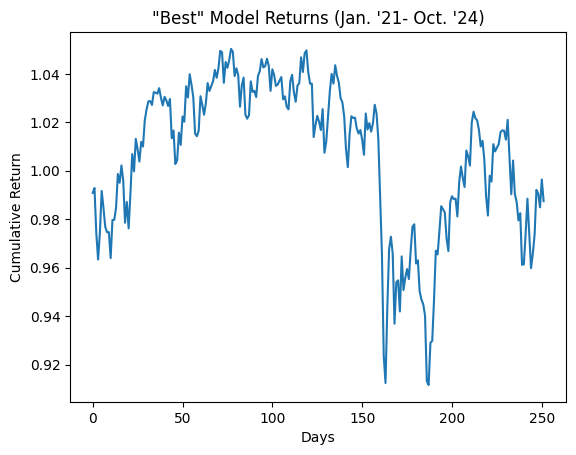

In [52]:
# Plot cumulative portfolio returns
cumulative_return_best = np.cumprod(1 + portfolio_returns_best)

plt.plot(cumulative_return_best)
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("\"Best\" Model Returns (Jan. \'21- Oct. \'24)")
plt.show()

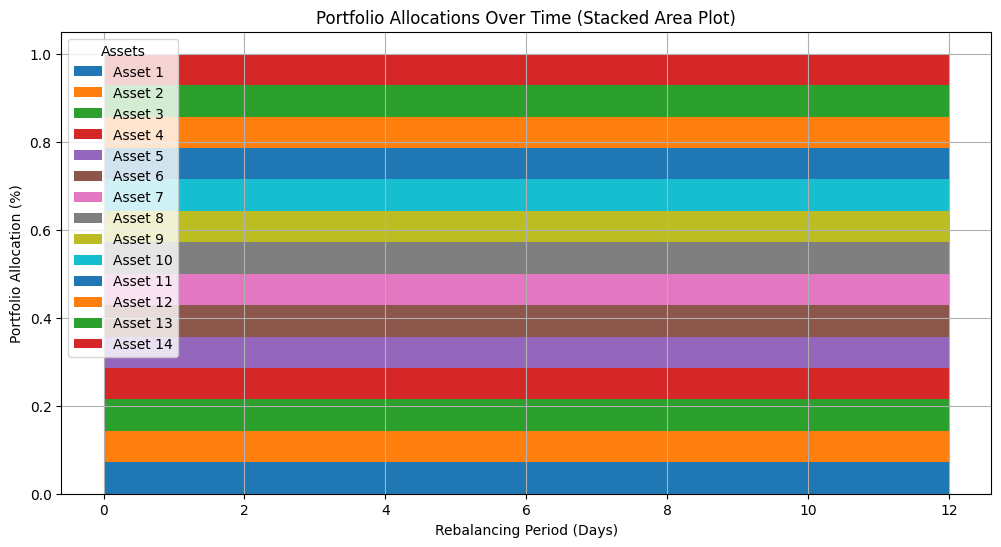

In [53]:
# Using the actual data from weight_history
num_rebalancing_periods, num_assets = weight_history_best.shape

# Define asset names (replace with your actual list of asset tickers)
asset_names = [f"Asset {i + 1}" for i in range(num_assets)]  # Replace with `tickers` if you have it

# Create the stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(range(num_rebalancing_periods), weight_history_best.T, labels=asset_names)

# Adding labels, legend, and title
plt.xlabel("Rebalancing Period (Days)")
plt.ylabel("Portfolio Allocation (%)")
plt.title("Portfolio Allocations Over Time (Stacked Area Plot)")
plt.legend(title="Assets", loc="upper left")
plt.grid()

# Display the plot
plt.show()

## Last Model

In [54]:
# Create the stats directory if it does not exist
stats_dir = "stats"
os.makedirs(stats_dir, exist_ok=True)

# Initialize the agent and load the trained model
agent = DDPGAgent(num_assets=len(tickers))
agent.actor.load_state_dict(torch.load("saved_models/last_actor_7-1.pth"))
agent.actor.eval()  # Set the actor in evaluation mode

# Set the rebalancing period
rebalance_period = 20

# Lists to store the daily portfolio returns and weight history
portfolio_returns_last = []
weight_history_last = []

# Initialize state for the first rebalancing period
state = None
weights = None  # Portfolio weights allocated by the agent

# Start the testing loop
for i in range(STD_WINDOW_SIZE + WINDOW_SIZE, len(asset_returns)):
    # Every `rebalance_period` days, use the agent to determine new weights
    if i % rebalance_period == 0:
        # Get the current state from the environment
        window_data = asset_returns[i - STD_WINDOW_SIZE - WINDOW_SIZE:i]
        returns, volatilities, drawdowns = calculate_features(window_data, WINDOW_SIZE)
        state = create_state_matrix(returns, volatilities, drawdowns)

        # Calculate the rolling covariance matrix
        cov = data.iloc[i - WINDOW_SIZE:i].cov()

        # Store the covariance matrix as part of the state
        state = {
            'features': state,  # Original features (returns, volatilities, drawdowns)
            'covariance': cov.values  # Covariance matrix
        }

        # Get portfolio weights from the agent
        with torch.no_grad():
            weights = agent.act(state, add_noise=False)  # No exploration noise during testing
            weights = np.clip(weights, 0, 1)       # Clip weights to ensure they are within bounds
            weights /= weights.sum()               # Normalize to ensure they sum to 1

        # Store the current weights in the weight history
        weight_history_last.append(weights)

    # Calculate portfolio return for the day based on the fixed weights
    daily_portfolio_return = np.dot(weights, asset_returns.iloc[i].values)
    portfolio_returns_last.append(daily_portfolio_return)

# Convert the list of portfolio returns to a NumPy array
portfolio_returns_last = np.array(portfolio_returns_last)

# Convert the weight history to a NumPy array or DataFrame for further analysis
weight_history_last = np.array(weight_history_last)

# Save the portfolio returns and weight history to the stats folder
np.save(os.path.join(stats_dir, f"last_portfolio_returns_7-1.npy"), portfolio_returns_last)
np.save(os.path.join(stats_dir, f"last_weight_history_7-1.npy"), weight_history_last)

# Print the shape of the weight history for verification
print(f"Weight History Shape: {weight_history_last.shape}")

Weight History Shape: (13, 14)


In [55]:
# Define the number of trading days per year
trading_days_per_year = 252

# Calculate annualized return
annualized_return_last = np.mean(portfolio_returns_last) * trading_days_per_year

# Calculate annualized volatility
annualized_volatility_last = np.std(portfolio_returns_last) * np.sqrt(trading_days_per_year)

# Calculate Sharpe ratio (assuming a risk-free rate of 0 for simplicity)
sharpe_ratio_last = annualized_return_last / annualized_volatility_last if annualized_volatility_last != 0 else np.nan

# Calculate the max drawdown
max_drawdown_last = calculate_max_drawdown(portfolio_returns_last)

# Calculate Calmar ratio (handle divide by zero)
calmar_ratio_last = annualized_return_last / max_drawdown_last if max_drawdown_last != 0 else np.nan

# Display results
print("Days: ", len(portfolio_returns_last))
print("Annualized Return:", annualized_return_last)
print("Annualized Volatility:", annualized_volatility_last)
print("Sharpe Ratio:", sharpe_ratio_last)
print("Max Drawdown: ", max_drawdown_last)
print("Calmar Ratio: ", calmar_ratio_last)

Days:  252
Annualized Return: 8.345471862208909e-05
Annualized Volatility: 0.15920728390829855
Sharpe Ratio: 0.0005241890733476616
Max Drawdown:  0.1320758578101603
Calmar Ratio:  0.0006318695937757453


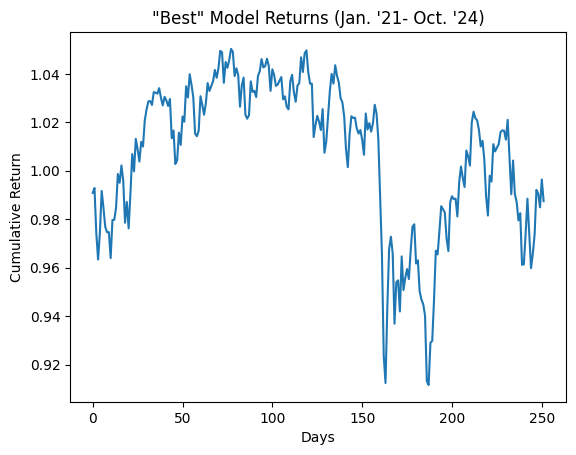

In [56]:
# Plot cumulative portfolio returns
cumulative_return_last = np.cumprod(1 + portfolio_returns_last)

plt.plot(cumulative_return_last)
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.title("\"Best\" Model Returns (Jan. \'21- Oct. \'24)")
plt.show()

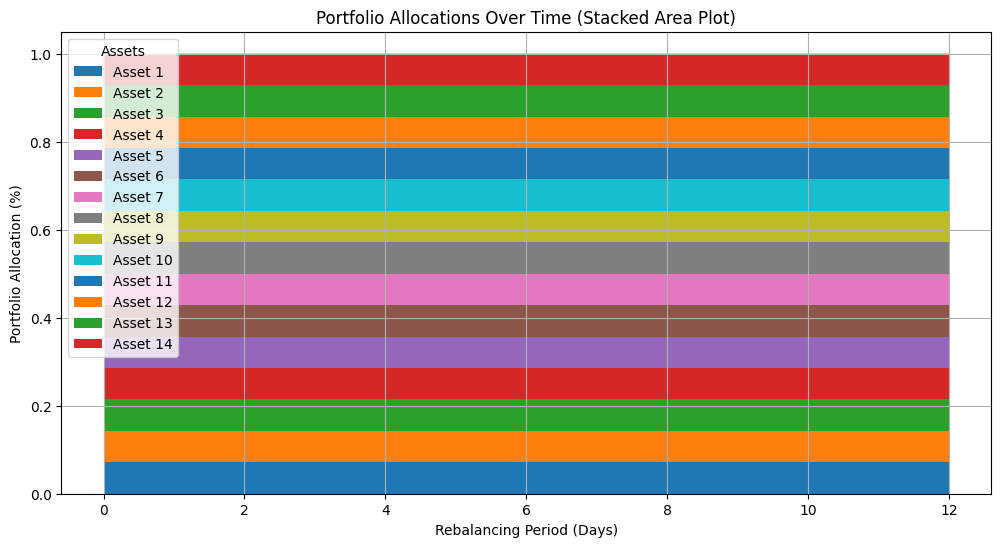

In [57]:
# Using the actual data from weight_history
num_rebalancing_periods, num_assets = weight_history_last.shape

# Define asset names (replace with your actual list of asset tickers)
asset_names = [f"Asset {i + 1}" for i in range(num_assets)]  # Replace with `tickers` if you have it

# Create the stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(range(num_rebalancing_periods), weight_history_last.T, labels=asset_names)

# Adding labels, legend, and title
plt.xlabel("Rebalancing Period (Days)")
plt.ylabel("Portfolio Allocation (%)")
plt.title("Portfolio Allocations Over Time (Stacked Area Plot)")
plt.legend(title="Assets", loc="upper left")
plt.grid()

# Display the plot
plt.show()